In [0]:
import tensorflow as tf
import os
import numpy as np
import json
from PIL import Image
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
from matplotlib.collections import PatchCollection
import cv2 as cv
from skimage import io
from skimage.segmentation import quickshift
import glob
import seaborn as sns

In [0]:
import os
import glob
import zipfile
import functools
from skimage import io
from skimage.segmentation import quickshift
import glob
from skimage.transform import rescale, resize, downscale_local_mean

from sklearn.model_selection import train_test_split
import matplotlib as mpl
mpl.rcParams['axes.grid'] = False
mpl.rcParams['figure.figsize'] = (12,12)

from sklearn.model_selection import train_test_split
import matplotlib.image as mpimg
import pandas as pd
from PIL import Image
import cv2 as cv

In [0]:
%matplotlib inline

In [7]:
!apt-get install -y -qq software-properties-common python-software-properties module-init-tools
!add-apt-repository -y ppa:alessandro-strada/ppa 2>&1 > /dev/null
!apt-get update -qq 2>&1 > /dev/null
!apt-get -y install -qq google-drive-ocamlfuse fuse
from google.colab import auth
auth.authenticate_user()
from oauth2client.client import GoogleCredentials
creds = GoogleCredentials.get_application_default()
import getpass
!google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret} < /dev/null 2>&1 | grep URL
vcode = getpass.getpass()
!echo {vcode} | google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret}



E: Package 'python-software-properties' has no installation candidate
Please, open the following URL in a web browser: https://accounts.google.com/o/oauth2/auth?client_id=32555940559.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive&response_type=code&access_type=offline&approval_prompt=force
··········
Please, open the following URL in a web browser: https://accounts.google.com/o/oauth2/auth?client_id=32555940559.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive&response_type=code&access_type=offline&approval_prompt=force
Please enter the verification code: Access token retrieved correctly.


In [0]:
!mkdir -p drive
!google-drive-ocamlfuse drive

In [0]:
PATH="drive/inter_iit/conv_data"
img_dir = os.path.join(PATH, "sat")
label_dir = os.path.join(PATH, "gt")

In [0]:
def scale_percentile(matrix):
    """Fixes the pixel value range to 2%-98% original distribution of values"""
    orig_shape = matrix.shape
    matrix = np.reshape(matrix, [matrix.shape[0]*matrix.shape[1], 3]).astype(float)
    
    # Get 2nd and 98th percentile
    mins = np.percentile(matrix, 1, axis=0)
    maxs = np.percentile(matrix, 99, axis=0) - mins
    
    matrix = (matrix - mins[None,:])/maxs[None,:]
    matrix = np.reshape(matrix, orig_shape)
    matrix = matrix.clip(0,1)
    return matrix

def scale_percentile_without_normalization(matrix):
    """Fixes the pixel value range to 2%-98% original distribution of values"""
    orig_shape = matrix.shape
    matrix = np.reshape(matrix, [matrix.shape[0]*matrix.shape[1], 3]).astype(float)
    
    # Get 2nd and 98th percentile
    mins = np.percentile(matrix, 1, axis=0)
    maxs = np.percentile(matrix, 99, axis=0) - mins
    
    matrix = (matrix - mins[None,:])/maxs[None,:]
    matrix = np.reshape(matrix, orig_shape)
    #matrix = matrix.clip(0,1)
    return matrix
def stretch_8bit(bands, lower_percent=2, higher_percent=98):
    out = np.z|eros_like(bands).astype(np.float32)
    for i in range(3):
        a = 0
        b = 1
        c = np.percentile(bands[:, :, i], lower_percent)
        d = np.percentile(bands[:, :, i], higher_percent)
        t = a + (bands[:, :, i] - c) * (b - a) / (d - c)
        t[t < a] = a
        t[t > b] = b
        out[:, :, i] = t
    return out.astype(np.float32)

In [41]:
'''
mypath = 'drive/inter_iit/conv_data/gt'
onlyfiles = [f for f in os.listdir(mypath) if os.path.isfile(os.path.join(mypath, f))]
sz=(1024,1024)
for n in range(0, len(onlyfiles)):
    
    fname=os.path.join(label_dir, "{}.png".format(n))
    os.remove(fname)
    print(n)

  '''  

'\nmypath = \'drive/inter_iit/conv_data/gt\'\nonlyfiles = [f for f in os.listdir(mypath) if os.path.isfile(os.path.join(mypath, f))]\nsz=(1024,1024)\nfor n in range(0, len(onlyfiles)):\n    \n    fname=os.path.join(label_dir, "{}.png".format(n))\n    os.remove(fname)\n    print(n)\n\n  '

In [42]:
'''
mypath2 = 'drive/inter_iit/conv_data/sat'
onlyfiles = [f for f in os.listdir(mypath) if os.path.isfile(os.path.join(mypath2, f))]
sz=(1024,1024)
for n in range(0, len(onlyfiles)):
    
    fname=os.path.join(img_dir, "{}.png".format(n))
    os.remove(fname)
    print(n)
    
'''


'\nmypath2 = \'drive/inter_iit/conv_data/sat\'\nonlyfiles = [f for f in os.listdir(mypath) if os.path.isfile(os.path.join(mypath2, f))]\nsz=(1024,1024)\nfor n in range(0, len(onlyfiles)):\n    \n    fname=os.path.join(img_dir, "{}.png".format(n))\n    os.remove(fname)\n    print(n)\n    \n'

In [43]:
'''
mypath = 'drive/inter_iit/The-Eye-in-the-Sky-dataset/gt'
onlyfiles = [f for f in os.listdir(mypath) if os.path.isfile(os.path.join(mypath, f))]
sz=(1024,1024)


images = []
for n in range(0, len(onlyfiles)):
    im = io.imread(os.path.join(mypath, onlyfiles[n]))
    fname=os.path.join(label_dir, "{}.png".format(n))
    plt.imsave(fname, im)
    im=resize(im, sz)#.reshape(-1)
    images.append(im)
    print(im.shape)
    #df2 = pd.DataFrame(im.reshape(-1))
    #df = pd.concat([df, df2], axis=1, ignore_index=True)
    k = k + 1
    print(k)
#print(df)


   
images_gt = np.asarray(images)

print(images_gt.shape)
   


'''

'\nmypath = \'drive/inter_iit/The-Eye-in-the-Sky-dataset/gt\'\nonlyfiles = [f for f in os.listdir(mypath) if os.path.isfile(os.path.join(mypath, f))]\nsz=(1024,1024)\n\n\nimages = []\nfor n in range(0, len(onlyfiles)):\n    im = io.imread(os.path.join(mypath, onlyfiles[n]))\n    fname=os.path.join(label_dir, "{}.png".format(n))\n    plt.imsave(fname, im)\n    im=resize(im, sz)#.reshape(-1)\n    images.append(im)\n    print(im.shape)\n    #df2 = pd.DataFrame(im.reshape(-1))\n    #df = pd.concat([df, df2], axis=1, ignore_index=True)\n    k = k + 1\n    print(k)\n#print(df)\n\n\n   \nimages_gt = np.asarray(images)\n\nprint(images_gt.shape)\n   \n\n\n'

In [44]:

'''
mypath = 'drive/inter_iit/The-Eye-in-the-Sky-dataset/sat'
onlyfiles = [f for f in os.listdir(mypath) if os.path.isfile(os.path.join(mypath, f))]


images_sat = []

for n in range(0, len(onlyfiles)):
    im = io.imread(os.path.join(mypath, onlyfiles[n]))
    im_rgb=im[...,0:3]
    
    fixed_im = scale_percentile(im_rgb)
    im=fixed_im
    print(fixed_im.shape)
    fname=os.path.join(img_dir, "{}.png".format(n))
    plt.imsave(fname, fixed_im)
    im=resize(im, sz)#.reshape(-1)
    
    images_sat.append(im)
    print(im.shape)
    #df2 = pd.DataFrame(im.reshape(-1))
    #df = pd.concat([df, df2], axis=1, ignore_index=True)
    
    print(n)
#print(df)
   
images_sat = np.asarray(images_sat)
print(images_sat[2])

print(images_sat.shape)

'''


'\nmypath = \'drive/inter_iit/The-Eye-in-the-Sky-dataset/sat\'\nonlyfiles = [f for f in os.listdir(mypath) if os.path.isfile(os.path.join(mypath, f))]\n\n\nimages_sat = []\n\nfor n in range(0, len(onlyfiles)):\n    im = io.imread(os.path.join(mypath, onlyfiles[n]))\n    im_rgb=im[...,0:3]\n    \n    fixed_im = scale_percentile(im_rgb)\n    im=fixed_im\n    print(fixed_im.shape)\n    fname=os.path.join(img_dir, "{}.png".format(n))\n    plt.imsave(fname, fixed_im)\n    im=resize(im, sz)#.reshape(-1)\n    \n    images_sat.append(im)\n    print(im.shape)\n    #df2 = pd.DataFrame(im.reshape(-1))\n    #df = pd.concat([df, df2], axis=1, ignore_index=True)\n    \n    print(n)\n#print(df)\n   \nimages_sat = np.asarray(images_sat)\nprint(images_sat[2])\n\nprint(images_sat.shape)\n\n'

In [45]:
mypath = 'drive/inter_iit/conv_data/gt'
onlyfiles = [f for f in os.listdir(mypath) if os.path.isfile(os.path.join(mypath, f))]
sz=(1024,1024)


images = []
for n in range(0, len(onlyfiles)):
    im = io.imread(os.path.join(mypath, onlyfiles[n]))[...,0:3]
    fname=os.path.join(label_dir, "{}.png".format(n))
    #plt.imsave(fname, im)
    im=resize(im, sz)#.reshape(-1)
    images.append(im)
    print(im.shape)
    #df2 = pd.DataFrame(im.reshape(-1))
    #df = pd.concat([df, df2], axis=1, ignore_index=True)
    n
#print(df)


   
images_gt = np.asarray(images)

print(images_gt.shape)

/usr/local/lib/python3.6/dist-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(14, 1024, 1024, 3)


In [16]:
mypath = 'drive/inter_iit/conv_data/sat'
onlyfiles = [f for f in os.listdir(mypath) if os.path.isfile(os.path.join(mypath, f))]


images_sat = []

for n in range(0, len(onlyfiles)):
    im = io.imread(os.path.join(mypath, onlyfiles[n]))[...,0:3]
    
    
    im=resize(im, sz)#.reshape(-1)
    
    images_sat.append(im)
    print(im.shape)
    n
    

images_sat = np.asarray(images_sat)
#print(images_sat[2])

print(images_sat.shape)

/usr/local/lib/python3.6/dist-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(14, 1024, 1024, 3)


In [0]:
df_x = pd.DataFrame(images_sat.flatten())
df_y = pd.DataFrame(images_gt.flatten())

In [57]:
print(df_x.shape)

(44040192, 1)


In [0]:
a=df_x.values

In [60]:
a=a.reshape(14,256,256,3)

ValueError: ignored

In [6]:
x_train_filenames = []
y_train_filenames = []
for index in range( 14):
  
  x_train_filenames.append(os.path.join(img_dir, "{}.png".format(index)))
  y_train_filenames.append(os.path.join(label_dir, "{}.png".format(index)))
  #print(index)

print(len(x_train_filenames))  

14


In [0]:

display_num = 5
nu=len(x_train_filenames)
r_choices = np.random.choice(nu, display_num)

plt.figure(figsize=(10, 15))
for i in range(0, display_num * 2, 2):
  img_num = r_choices[i // 2]
  x_pathname = x_train_filenames[img_num]
  y_pathname = y_train_filenames[img_num]
  
  plt.subplot(display_num, 2, i + 1)
  print(io.imread(x_train_filenames[img_num])[...,0:3].shape)
  plt.imshow((io.imread(x_pathname)[...,0:3]))
  plt.title("Original Image")
  
  example_labels = Image.open(y_pathname)
  label_vals = np.unique(example_labels)
  #print(np.unique(io.imread(y_train_filenames[img_num])))
  plt.subplot(display_num, 2, i + 2)
  plt.imshow(example_labels)
  plt.title("Masked Image")  
  
plt.suptitle("Examples of Images and their Masks")
plt.show()

In [0]:
PATH="drive/inter_iit/split_data"
img_dir = os.path.join(PATH, "sat")
label_dir = os.path.join(PATH, "gt")

In [7]:

h,w=256,256

split_sat=[]
split_gt=[]
t=0
for i in range(0, 14):
  
  img_num=i
  x,y=0,0
  x_pathname = x_train_filenames[img_num]
  y_pathname = y_train_filenames[img_num]
  im_sat=io.imread(x_pathname)[...,0:3]
  im_gt=io.imread(y_pathname)[...,0:3]
  n=i
  print(i)
  
  while 1:
    x=0
    while 1:
      
      fname_lab=os.path.join(label_dir, "{}_{}_{}.png".format(n,x,y))
      fname_img=os.path.join(img_dir, "{}_{}_{}.png".format(n,x,y))
      a,b,c=im_sat[y:y+h, x:x+w].shape
      c,d,f=im_gt[y:y+h, x:x+w].shape
      
      
      if(a==256 and b==256 and c==256 and d==256):
        
        t=t+1
        
        #print(t)
        if(t==1):
          crop_img_x = im_sat[y:y+h, x:x+w]#.flatten()
          a=crop_img_x.reshape(1,h*w*3)
          #df_sat=pd.DataFrame(a)
          crop_img_y = im_gt[y:y+h, x:x+w] 
          b=crop_img_y.reshape(1,h*w*3)
          #df_gt=pd.DataFrame(b)
          #print("dddddddddd")
        else:
          crop_img_x = im_sat[y:y+h, x:x+w]#.flatten()
          a=crop_img_x.reshape(1,h*w*3)
          #temp=pd.DataFrame(a)
          #df_sat = pd.concat([df_sat, temp], axis=0, ignore_index=True)
          #plt.imsave(fname_img,crop_img_x)
          #print(crop_img_y.shape)
          split_sat.append(crop_img_x)

          crop_img_y = im_gt[y:y+h, x:x+w]#.flatten()
          b=crop_img_y.reshape(1,h*w*3)
          #temp2=pd.DataFrame(b)
          #df_gt = pd.concat([df_gt, temp2], axis=0, ignore_index=True)
          #plt.imsave(fname_lab,crop_img_y)
          split_gt.append(crop_img_y)
      x=x+40
     # print(x)
      if(x>=750):
        break
    y=y+40
    if(y>=750):
      break
      
    
  
 

0
1
2
3
4
5
6
7
8
9
10
11
12
13


In [0]:

split_sat = np.asarray(split_sat)
split_gt = np.asarray(split_gt)

In [0]:
print(df_sat.shape)
print(df_sat)



In [0]:
df_sat.to_csv('drive/inter_iit/split_data/sat/df_sat.csv')

In [0]:
df_gt.to_csv('drive/inter_iit/split_data/gt/df_gt.csv')

In [14]:
print(split_sat.shape)

(3724, 256, 256, 3)


In [0]:
df_x = pd.DataFrame.from_records(split_sat)
df_y = pd.DataFrame.from_records(split_gt)
print(df_x[1])


In [0]:

img_shape = (256, 256, 3)
batch_size = 64
epochs = 5

In [0]:
#x_train, x_val, y_train, y_val= train_test_split(df_sat.values, df_gt.values, test_size=0.3, random_state=42)

In [0]:
x_train, x_val, y_train, y_val= train_test_split(split_sat, split_gt, test_size=0.3, random_state=42)

In [12]:
num_train_examples = len(x_train)
num_val_examples = len(x_val)
print(num_train_examples)

2606


In [13]:

from __future__ import division

import numpy as np
from keras.models import Model
from keras.layers import Input, merge, Convolution2D, MaxPooling2D, UpSampling2D, Cropping2D

from keras import backend as K

import keras
import h5py

from keras.layers.normalization import BatchNormalization


from keras.optimizers import Nadam
from keras.callbacks import History
import pandas as pd
from keras.backend import categorical_crossentropy

import datetime
import os

import random
import threading
from tensorflow.python.keras import layers
from keras.models import model_from_json
import tensorflow.contrib as tfcontrib
from tensorflow.python.keras import layers
from tensorflow.python.keras import losses
from tensorflow.python.keras import models
from tensorflow.python.keras import backend as K
from keras import utils

Using TensorFlow backend.


In [0]:
def conv_block(input_tensor, num_filters):
  encoder = layers.Conv2D(num_filters, (3, 3), padding='same')(input_tensor)
  encoder = layers.BatchNormalization()(encoder)
  encoder = layers.Activation('relu')(encoder)
  encoder = layers.Conv2D(num_filters, (3, 3), padding='same')(encoder)
  encoder = layers.BatchNormalization()(encoder)
  encoder = layers.Activation('relu')(encoder)
  return encoder

def encoder_block(input_tensor, num_filters):
  encoder = conv_block(input_tensor, num_filters)
  encoder_pool = layers.MaxPooling2D((2, 2), strides=(2, 2))(encoder)
  
  return encoder_pool, encoder

def decoder_block(input_tensor, concat_tensor, num_filters):
  decoder = layers.Conv2DTranspose(num_filters, (2, 2), strides=(2, 2), padding='same')(input_tensor)
  decoder = layers.concatenate([concat_tensor, decoder], axis=-1)
  decoder = layers.BatchNormalization()(decoder)
  decoder = layers.Activation('relu')(decoder)
  decoder = layers.Conv2D(num_filters, (3, 3), padding='same')(decoder)
  decoder = layers.BatchNormalization()(decoder)
  decoder = layers.Activation('relu')(decoder)
  decoder = layers.Conv2D(num_filters, (3, 3), padding='same')(decoder)
  decoder = layers.BatchNormalization()(decoder)
  decoder = layers.Activation('relu')(decoder)
  return decoder

In [15]:
inputs = layers.Input(shape=img_shape)

# 256
print(inputs.shape)
encoder0_pool, encoder0 = encoder_block(inputs, 32)
# 128
print(encoder0_pool.shape)
encoder1_pool, encoder1 = encoder_block(encoder0_pool, 64)
# 64

encoder2_pool, encoder2 = encoder_block(encoder1_pool, 128)
# 32

encoder3_pool, encoder3 = encoder_block(encoder2_pool, 256)
# 16

encoder4_pool, encoder4 = encoder_block(encoder3_pool, 512)
# 8

center = conv_block(encoder4_pool, 1024)
# center

decoder4 = decoder_block(center, encoder4, 512)
# 16

decoder3 = decoder_block(decoder4, encoder3, 256)
# 32

decoder2 = decoder_block(decoder3, encoder2, 128)
# 64

decoder1 = decoder_block(decoder2, encoder1, 64)
# 128

decoder0 = decoder_block(decoder1, encoder0, 32)

#encoder4_pool, encoder4 = encoder_block(encoder3_pool, 512)
outputs = layers.Conv2D(3, (1, 1), activation='sigmoid')(decoder0)






(?, 256, 256, 3)
(?, 128, 128, 32)


In [0]:
model = models.Model(inputs=[inputs], outputs=[outputs])

In [0]:
def dice_coeff(y_true, y_pred):
    smooth = 1.
    # Flatten
    y_true_f = tf.reshape(y_true, [-1])
    y_pred_f = tf.reshape(y_pred, [-1])
    intersection = tf.reduce_sum(y_true_f * y_pred_f)
    score = (2. * intersection + smooth) / (tf.reduce_sum(y_true_f) + tf.reduce_sum(y_pred_f) + smooth)
    return score

In [0]:
def dice_loss(y_true, y_pred):
    loss = 1 - dice_coeff(y_true, y_pred)
    return loss

In [0]:
def bce_dice_loss(y_true, y_pred):
    loss = losses.categorical_crossentropy(y_true, y_pred) + dice_loss(y_true, y_pred)
    return loss


In [0]:
def jaccard_coef(y_true, y_pred):
    intersection = K.sum(y_true * y_pred, axis=[0, -1, -2])
    sum_ = K.sum(y_true + y_pred, axis=[0, -1, -2])

    jac = (intersection + smooth) / (sum_ - intersection + smooth)

    return K.mean(jac)


def jaccard_coef_int(y_true, y_pred):
    y_pred_pos = K.round(K.clip(y_pred, 0, 1))

    intersection = K.sum(y_true * y_pred_pos, axis=[0, -1, -2])
    sum_ = K.sum(y_true + y_pred_pos, axis=[0, -1, -2])

    jac = (intersection + smooth) / (sum_ - intersection + smooth)

    return K.mean(jac)


def jaccard_coef_loss(y_true, y_pred):
    return -K.log(jaccard_coef(y_true, y_pred)) + categorical_crossentropy(y_pred, y_true)

In [0]:
model.compile(optimizer='adam', loss=bce_dice_loss, metrics=[dice_loss])

#model.summary()

In [0]:
save_model_path = 'drive/inter_iit/model/weights.hdf5'
cp = tf.keras.callbacks.ModelCheckpoint(filepath=save_model_path, monitor='val_dice_loss', save_best_only=True, verbose=1)

In [64]:
print(x_val.shape)

(1117, 256, 256, 3)


In [0]:
print(x_train[2])

In [0]:
im_rows = 256 
im_cols = 256
x_test=x_val
y_test=y_val

im_shape = (im_rows, im_cols, 3)

x_train = x_train.reshape(x_train.shape[0], *im_shape)
y_train = y_train.reshape(y_train.shape[0], *im_shape)
x_test = x_test.reshape(x_test.shape[0], *im_shape)
y_test = x_test.reshape(y_test.shape[0], *im_shape)


In [67]:

print(x_train.shape)

(2606, 256, 256, 3)


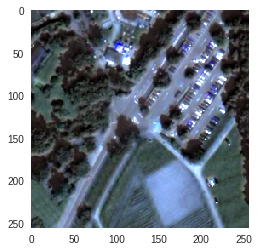

In [68]:

plt.imshow(x_train[1])

In [0]:
'''parse function to be used. This function is needed to do 
the preprocessing of data like reshaping ,
converting to tensors from numpy arrays ,one-hot encoding ,etc.'''
def _parse_(x,y):
    x = tf.reshape(x,(784,)) #reshape to 784 as expected.
    x = tf.cast(x,tf.float32) #cast to float32 as the weights are float32.
    # y = tf.one_hot(y,10) #should be one hot encoded but tensorflow is throwing error .idky??
    y = tf.cast(y,tf.int32) #cast to tensor of int32
    return (dict({'image':x}),y) #return tuple of dict of feature name with value and label.

In [0]:
def train_input_fn(x_train,y_train,batch_size=64):
    ##Here we are using dataset API.
    '''
    take the data from tensor_slices i.e. an array of datapoints in simple words.
    '''
    dataset = tf.data.Dataset.from_tensor_slices((x_train,y_train)) 
    
    
    dataset = dataset.map(lambda x,y:_parse_(x,y)).shuffle(buffer_size=128) \
                .batch(batch_size).make_one_shot_iterator()
    
    return dataset.get_next()

In [0]:
epochs=5
batch_size=64

In [31]:
history=model.fit(input_fn=tf.estimator.inputs.numpy_input_fn(dict({'image':x_train}),
                                                        np.array(y_train,np.int32),shuffle=True),steps=10)

TypeError: ignored

In [35]:
import time
t1 = time.time()
model.fit(input_fn=lambda:train_input_fn(x_train,y_train,64),steps=150)
t2= time.time()
print('---------{}'.format(t2 - t1))



TypeError: ignored

In [0]:
t1 = time.time()
model.train(input_fn=lambda:train_input_fn(x_train,y_train,64),steps=251)
t2= time.time()
print('---------{}'.format(t2 - t1))

In [1]:
history = model.fit((x_train/255,y_train/255 ),
                   steps_per_epoch=int(np.ceil(num_train_examples / float(batch_size))),
                   epochs=epochs,
                   validation_data=(x_val/255,y_val/255),
                   validation_steps=int(np.ceil(num_val_examples / float(batch_size))),
                   callbacks=[cp])

NameError: ignored

In [0]:
dice = history.history['dice_loss']
val_dice = history.history['val_dice_loss']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, dice, label='Training Dice Loss')
plt.plot(epochs_range, val_dice, label='Validation Dice Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Dice Loss')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')

plt.show()

In [0]:
# Alternatively, load the weights directly: model.load_weights(save_model_path)
model = models.load_model(save_model_path, custom_objects={'bce_dice_loss': bce_dice_loss,
                                                           'dice_loss': dice_loss})

In [0]:

# Let's visualize some of the outputs 
data_aug_iter = val_ds.make_one_shot_iterator()
next_element = data_aug_iter.get_next()

# Running next element in our graph will produce a batch of images
plt.figure(figsize=(10, 20))
for i in range(5):
  batch_of_imgs, label = tf.keras.backend.get_session().run(next_element)
  img = batch_of_imgs[0]
  predicted_label = model.predict(batch_of_imgs)[0]

  plt.subplot(5, 3, 3 * i + 1)
  plt.imshow(img)
  plt.title("Input image")
  
  plt.subplot(5, 3, 3 * i + 2)
  plt.imshow(label[0, :, :, :])
  plt.title("Actual Mask")
  plt.subplot(5, 3, 3 * i + 3)
  plt.imshow(predicted_label[:, :, :])
  plt.title("Predicted Mask")
plt.suptitle("Examples of Input Image, Label, and Prediction")
plt.show()